In [2]:
library(data.table)
library(scales)
library(arrow)
library(tidyverse)
library(cowplot)
library(gridExtra)

setDTthreads(10)
setwd("/gpfs/commons/groups/lappalainen_lab/sghatan/stingseq_eqtl_overlap/Post_coloc_analysis/")

# Load cres
cres_w_grnas = fread("cres_with_grnas.txt")
cres_w_grnas_egene = fread("cres_with_grna_eqtls.txt")

# Load gold standard causal gene list
gold_genes = fread("rare_genes_list.txt")

# filter eQTLs and crispri overlapping gold standard gene list
cgenes = cres_w_grnas %>% 
  filter(ensembl_id %in% gold_genes$rare_genes, significant == T) %>% 
  distinct(grna_target, .keep_all = T)

egenes = cres_w_grnas_egene %>% 
  filter(ensembl_id %in% gold_genes$rare_genes) %>% 
  distinct(grna_target, .keep_all = T)

# Load eqtl distances
eqtl.cat.distances = fread("eQTL_gene_distances/eqtl_cat_gene_distances.txt")
sc.eqtl.distances = fread("eQTL_gene_distances/Onek1k_gene_distance.txt")
gtex.distance = fread("eQTL_gene_distances/GTEx_gene_distance.txt")
mage.distance = fread("eQTL_gene_distances/MAGE_gene_distance.txt")

# load power calculations
gtex = fread("power_results/GTEx.power.results.txt")

plot_list <- list()  # Create an empty list to store plots

plot.heatmap = function(x, y){
  
  cat("Plotting heatmap for", x , "\n")
  
  # filter distance dataframe to snp
  eqtl.cat.region = eqtl.cat.distances %>% 
    filter(grna_target == x) %>% 
    mutate(tss_distance = position-start) %>%
    dplyr::select(grna_target, study = eqtl, gene_name, pvalue, tss_distance)
  
  sc.eqtl.region = sc.eqtl.distances %>% 
    filter(grna_target == x, !cell_type %in% c("Other_T_cells", "Other_cells")) %>%
    dplyr::select(grna_target, study = cell_type, gene_name, pvalue = pval_nominal, tss_distance = distance)
  
  gtex.region = gtex.distance %>% 
    filter(grna_target == x) %>%
    mutate(study = "GTEx") %>%
    dplyr::select(grna_target, study,gene_name, pvalue = pval_nominal, tss_distance)
  
  mage.region = mage.distance %>%
    filter(grna_target == x) %>%
    mutate(study = "MAGE") %>%
    dplyr::select(grna_target, study, gene_name=geneSymbol, pvalue = pval_nominal, tss_distance)
  
  eqtl.region = rbind(eqtl.cat.region,sc.eqtl.region,gtex.region,mage.region) %>%
    mutate(pvalue = (pvalue/1e-03)*0.10) %>% # scale p-value to a line with crispr
    mutate(pvalue = ifelse(pvalue > 1, 1, pvalue))
  
  crispr.region = cres_w_grnas %>% 
    filter(grna_target == x) %>%
    mutate(study = "CRISPRi") %>%
    dplyr::select(grna_target, study, gene_name, pvalue, tss_distance)
  
  dis_rank = rbind(eqtl.region,crispr.region) %>%
    distinct(gene_name,.keep_all=T) %>%
    mutate(dis_rank = rank(tss_distance*-1),
           zero_rank = rank(abs(tss_distance))) %>%
    arrange(dis_rank)
  
  # what is the position of the median ranked gene
  median_rank = round(median(dis_rank$dis_rank))
  median_value = dis_rank$tss_distance[dis_rank$dis_rank == median_rank]
  
  heatmap_data <- rbind(eqtl.region,crispr.region) %>%
    mutate(log_pval = -log(pvalue)) %>%
    dplyr::select(study, gene_name, log_pval) %>%
    filter(gene_name != "") %>%
    arrange(desc(log_pval)) %>%
    distinct(study, .keep_all=T) %>%
    pivot_wider(names_from = gene_name, values_from = log_pval) %>%
    column_to_rownames("study")
  
  heatmap_long <- heatmap_data %>%
    rownames_to_column("study") %>%
    pivot_longer(cols = -study, names_to = "gene_name", values_to = "pvalue") %>%
    filter(gene_name %in% dis_rank$gene_name) %>%
    left_join(dis_rank[,c("gene_name","tss_distance")], "gene_name")
  
  heatmap_long$pval_filled <- ifelse(is.na(heatmap_long$pvalue), -Inf, heatmap_long$pvalue)
  #heatmap_long$study <- factor(heatmap_long$study, levels = rev(c("NK_cells", "B_cells", "CD4_T_cells", "CD8_T_cells", "DC_mean", "Mono_cells","GTEx","CRISPRi")))
  heatmap_long$gene_name = factor(heatmap_long$gene_name, levels = dis_rank$gene_name)
  # set center of plot for title
  tent5c_position <- which(levels(heatmap_long$gene_name) == dis_rank$gene_name[dis_rank$zero_rank == 1])
  
  if (!dir.exists("plots/heatmaps")) {
    
    print("No directory")
    
    dir.create("plots/heatmaps", recursive = TRUE)
  }
  
  # Plotting the heatmap
  #png(paste0("plots/heatmaps/", x, ".png"), width = 14, height = 4, units = "in", res = 300)
  
  plot = ggplot(heatmap_long, aes(x = gene_name, y = study, fill = pval_filled)) +
    geom_tile(aes(color = is.na(pvalue)), show.legend = TRUE) + # Show legend for z-scores
    scale_fill_gradientn(colors = c("white", "white", "red"),
                         values = rescale(c(0, 2, 10)), na.value = "gainsboro", oob = squish, limits = c(0, 10)) +  
    scale_color_manual(values = c("TRUE" = "gainsboro", "FALSE" = NA), guide = "none") + # Exclude color legend for NA tiles
    theme_cowplot() +
    labs(title = x, x = "Gene", y = "", fill = "-log10 p-value") +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1, color = ifelse(levels(heatmap_long$gene_name) == y, "blue", "black")),
      plot.title = element_text(hjust = 1/14*(tent5c_position-0.5), size = 12, margin = margin(b = 25)) # Center the title
    )
  
  print(plot)
  
  #dev.off()
  
  print("Done")
  
}

Warning message:
“package ‘arrow’ was built under R version 4.3.2”

Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp


── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()      masks data.table::between()
✖ readr::col_factor()   masks scales::col_factor()
✖ purrr::discard()      masks scales::discard()
✖ lubridate::duration() masks arrow::duration()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::first()        masks data.table::first()
✖ lubridate::hour()

Plotting heatmap for 1:118152241 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"


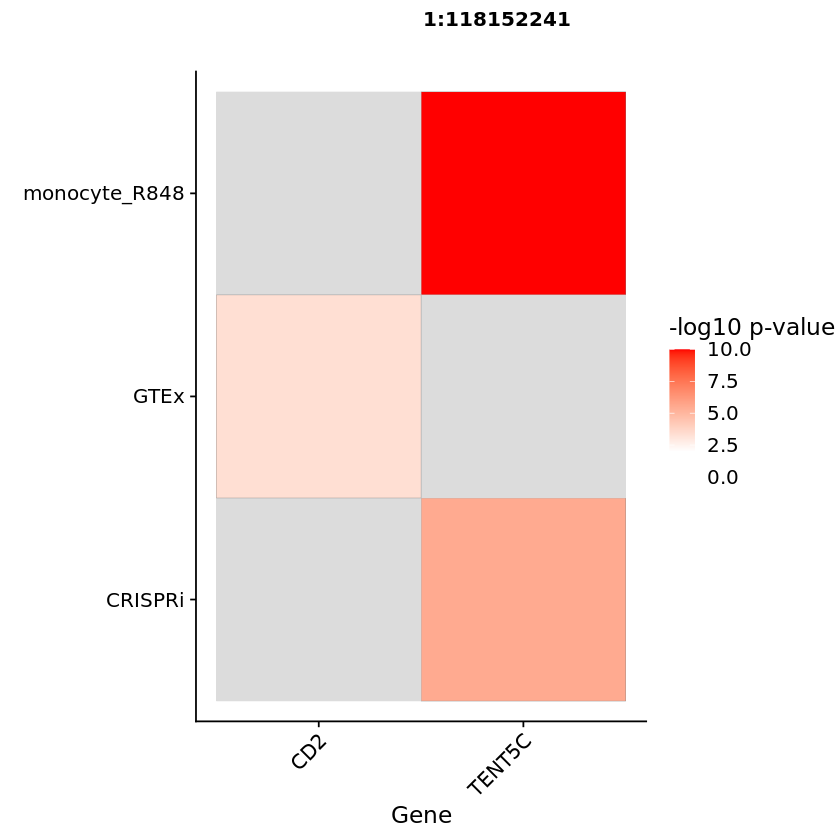

In [4]:
plot.heatmap(cgenes$grna_target[1], cgenes$gene_name[1])

In [6]:
#1:118152241
lapply(1:nrow(cgenes), function(x) plot.heatmap(cgenes$grna_target[x], cgenes$gene_name[x]))

Plotting heatmap for 1:118152241 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 3:195921311 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 3:128201889 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 7:50427982 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 8:41630405 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 9:135860412 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 9:135879542 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 10:71094504 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 10:65027610 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 12:54685880 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 12:54698408 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 13:113875080 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 14:103564820 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 16:88840462 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 21:36280376 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 19:12999458 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 7:100240296 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 16:170328 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 7:101499930 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 1:31241886 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 19:12994618 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for chr1:29210412-29210431 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for chr1:248018791-248018810 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for 4:55408999 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for chr4:55438121-55438140 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"
Plotting heatmap for chr11:5268102-5269244 


Warning message:
“Vectorized input to `element_text()` is not officially supported.
ℹ Results may be unexpected or may change in future versions of ggplot2.”


[1] "Done"


[[1]]
[1] "Done"

[[2]]
[1] "Done"

[[3]]
[1] "Done"

[[4]]
[1] "Done"

[[5]]
[1] "Done"

[[6]]
[1] "Done"

[[7]]
[1] "Done"

[[8]]
[1] "Done"

[[9]]
[1] "Done"

[[10]]
[1] "Done"

[[11]]
[1] "Done"

[[12]]
[1] "Done"

[[13]]
[1] "Done"

[[14]]
[1] "Done"

[[15]]
[1] "Done"

[[16]]
[1] "Done"

[[17]]
[1] "Done"

[[18]]
[1] "Done"

[[19]]
[1] "Done"

[[20]]
[1] "Done"

[[21]]
[1] "Done"

[[22]]
[1] "Done"

[[23]]
[1] "Done"

[[24]]
[1] "Done"

[[25]]
[1] "Done"

[[26]]
[1] "Done"